In [68]:
import pandas as pd
import numpy as np
import string
import re
import time

import matplotlib.pyplot as plt


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE 

from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras import metrics


In [3]:
# Read file
filename = 'data/judge-1377884607_tweet_product_company.csv'

sentiments_df = pd.read_csv(filename, encoding= 'unicode_escape') 


In [4]:
# Data overview
sentiments_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Randomly check tweet text for a couple of rows

pd.set_option('display.max_colwidth', None)
indexes = np.random.randint(0,len(sentiments_df),6)
sentiments_df['tweet_text'].loc[indexes]


988      Confusion over Google Circles. Google claim Circles is not being released at #sxsw and is not even in development. {link}
7248    Check it out! Great &amp; v. effective enviro app by @mention : Which Bin - {link} (iPhone 3gs+) #sxsw #sxswi #greatergood
4354                  My #sxsw moment - walking while looking down at iPhone and nearly ran into @mention and @mention at the ACC.
1330                                      A new app with a resourceful way to get connected: {link} #hashable #SXSW #iphone #droid
3973                                                              32gb black at&amp;t in stock!! Yes!! #SXSW #iPad2 #Austin #apple
7933                                     Epicurious, flipboard, CNN, wired, and MOMA as examples of good iPad design #SXSW  {link}
Name: tweet_text, dtype: object

In [6]:
# Check number of records, data types and which columns have nan

sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
# Check values for column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
# Confirm number of NaN in column 'emotion_in_tweet_is_directed_at'

sentiments_df['emotion_in_tweet_is_directed_at'].isna().sum()

5802

In [9]:
# Check values for column 'is_there_an_emotion_directed_at_a_brand_or_product'

sentiments_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [10]:

def find_company_name_v2(text,emotion_at):
    
    '''
    Go through text ('tweet_text' column) and determine whether it is about apple or google and
    return either 'apple' or 'google' according to search.
    If cannot tell company id from text, check emotion_at ('emotion_in_tweet_is_directed_at'
    column) for comapy id. If cannot find company id return 'cannot tell'.
    '''
    
    revised_emotion_at = str(emotion_at).lower()
    
    
    revised_text = str(text).lower()
    
    apple = ['apple','iphone','ipad']
    google = ['google','android']
    
    apple_count = 0
    google_count = 0
    
    for a in apple:
        apple_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(a), revised_text))
        
    for g in google:
        google_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(g), revised_text))
    

    if apple_count > google_count:
        return 'apple'
    elif google_count > apple_count:
        return 'google'
    elif revised_emotion_at != 'nan' and revised_emotion_at != 'default':
        for idx, item in enumerate(revised_emotion_at.split()):
            if item in apple:
                return 'apple'
            elif item in google:
                return 'google'
            else:
                if idx == len(revised_emotion_at.split()): 
                    return 'cannot tell'
    else:
        return 'cannot tell'

In [11]:
# Create a new column called 'company_name' and find whether the tweet is about apple,
# google or cannot tell using function find_company_name
 
sentiments_df['company_name'] = sentiments_df.apply(
    lambda s: find_company_name_v2(s['tweet_text'],s['emotion_in_tweet_is_directed_at']),axis=1) 

sentiments_df['company_name'].value_counts()


apple          5331
google         2814
cannot tell     948
Name: company_name, dtype: int64

In [12]:
# Tweets for which cannot tell whether comment directed to apple or google the
# sentiment is mostly neutral (over 95%)

cannot_tell = sentiments_df[sentiments_df['company_name'] == 'cannot tell']
cannot_tell['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    911
Positive emotion                       23
I can't tell                           10
Negative emotion                        4
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [13]:
# Drop any row where 'tweet_text' is nan
sentiments_df.drop(sentiments_df[sentiments_df['tweet_text'].isna()].index,inplace=True)

# Drop any row where 'is_there_an_emotion_directed_at_a_brand_or_product' says 'I can't tell'
column_name = 'is_there_an_emotion_directed_at_a_brand_or_product'
match = 'I can\'t tell'
sentiments_df.drop(sentiments_df[sentiments_df[column_name] == match].index, inplace=True)


# Drop any rows where column 'company_name' says 'cannot tell'
sentiments_df.drop(sentiments_df[sentiments_df['company_name'] == 'cannot tell'].index,
                  inplace=True)

# Drop any duplicated rows
sentiments_df.drop(sentiments_df[sentiments_df.duplicated()].index,inplace=True)

sentiments_df['company_name'].value_counts()

apple     5231
google    2748
Name: company_name, dtype: int64

In [14]:
# Create a function that returns 0 for negative sentiment, 1 for neutral sentiment
# and 2 for positive sentiment

def convert_emotion_tonumber(emotion):
    if emotion == 'Negative emotion':
        return 0
    elif emotion == 'Positive emotion':
        return 2
    else:
        return 1  # for neutral emotion

In [15]:
# Create a column called 'sentiment' and pass value from 
# 'is_there_an_emotion_directed_at_a_brand_or_product' to function convert_emotion_tonumber.

sentiments_df['sentiment'] = sentiments_df[
    'is_there_an_emotion_directed_at_a_brand_or_product'].map(
    lambda s: convert_emotion_tonumber(s))

sentiments_df['sentiment'].value_counts()

1    4467
2    2947
0     565
Name: sentiment, dtype: int64

In [16]:
sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          7979 non-null   object
 1   emotion_in_tweet_is_directed_at                     3273 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  7979 non-null   object
 3   company_name                                        7979 non-null   object
 4   sentiment                                           7979 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 374.0+ KB


In [17]:
# Create an intermediate dataframe that only contains columns 'tweet_text','company_name'
# sentiment

sentiments2_df = sentiments_df[['tweet_text','company_name','sentiment']].copy()


In [18]:
sentiments2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_text    7979 non-null   object
 1   company_name  7979 non-null   object
 2   sentiment     7979 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 249.3+ KB


In [19]:
# Determine total number of unique words in sentiments['tweet_text']

tweet_words = sentiments_df['tweet_text'].map(word_tokenize).values
total_vocabulary = set(word for tweet in tweet_words for word in tweet)
print (f'Total number of unique words in tweet_words: {len(total_vocabulary)}')


Total number of unique words in tweet_words: 12131


In [20]:
# Split sentiments2_df into two data frames where apple_df contains all tweets about apple
# google_df contains all tweets about google

apple_df = sentiments2_df[sentiments2_df['company_name'] == 'apple'].copy()
google_df = sentiments2_df[sentiments2_df['company_name'] == 'google'].copy()


In [21]:
# Split apple_df and google_df into train and test samples using train_test_split

X_train_app, X_test_app, y_train_app, y_test_app = train_test_split(apple_df['tweet_text'],
                                                apple_df['sentiment'],test_size = 0.4, 
                                                stratify = apple_df['sentiment'],
                                                random_state = 6781)

X_train_goo, X_test_goo, y_train_goo, y_test_goo = train_test_split(google_df['tweet_text'],
                                                google_df['sentiment'],test_size = 0.4, 
                                                stratify = google_df['sentiment'],
                                                random_state = 6782)


In [22]:
a = len(X_train_app)
g = len(X_train_goo)
a+g

4786

In [23]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
def nlp_doc_preparer(doc):
    '''
     - Customize nltk stop_words to include all punction marks
     - Split text into words containing letters
     - Make all letters lower case
     - Use pos_tag to mark up the words for a particular part of a speech
     - Use get_wordnet_pos to convert pos_tag to wordnet_pos
     - Convert word to root word with WordNetLemmatizer
     - Return processed document as a string of words
    '''
    
    custom_sw = stopwords.words('english')
    custom_punctuation = [c for c in list(string.punctuation) if(c not in ['!','?'])]
    custom_sw.extend(custom_punctuation)

    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in custom_sw]
    
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return ' '.join(doc)


In [25]:
# Combined X_train_app and X_train_goo into single series 
# and y_train_app and y_train_goo 

X_train_combined = pd.concat([X_train_app,X_train_goo])
y_train_combined = pd.concat([y_train_app,y_train_goo])



In [26]:
len(X_train_combined) == len(y_train_combined)

True

In [27]:
sum(X_train_combined.index == y_train_combined.index)

4786

In [28]:
# Process X_train_combined, X_test_app, X_test_goo with nlp_doc_preparer function

X_train_combined_processed = [nlp_doc_preparer(tweet) for tweet in X_train_combined]

X_test_app_processed = [nlp_doc_preparer(tweet) for tweet in X_test_app]
X_test_goo_processed = [nlp_doc_preparer(tweet) for tweet in X_test_goo]


In [29]:


def display_cross_validation_results(cross_val,model_name):
    '''
    Incoporate cross validation results into a pandas dataframe and display validation scores
    '''
    
    cross_val_results = pd.DataFrame(cross_val)
    
    accuracy = cross_val_results['mean_test_accuracy'][0]
    recall = cross_val_results['mean_test_recall'][0]
    precision = cross_val_results['mean_test_precision'][0]
    
    print('Validation','='*60)
    print(f'Validation results for {model_name}:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')

In [30]:

def display_prediction_results(prediction, actuall, company_name, model_name):
    '''
    Get predictions for X_test samples and display scores
    '''
    
    accuracy = accuracy_score(actuall,prediction)
    recall = recall_score(actuall, prediction, average = 'micro')
    precision = precision_score(actuall, prediction, average = 'micro')

    print('='*60)
    print(f'Predictions for {company_name}: {model_name}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}\n')


In [31]:
def display_confusion_matrix(model, X, y,company_name, model_name):
    print(f'Confusion matrix for: {company_name}')
    print(f'Model: {model_name}')
    plot_confusion_matrix(model,X,y)
    print('='*80)
    

In [51]:
# Use pipes to countVectorize X_train_combined_processed and then train MultinomialNB

start = time.time()

cv_mnb_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('mnb', MultinomialNB())])

grid_accuracy = make_scorer(accuracy_score)
grid_recall_micro = make_scorer(recall_score, average = 'micro')
grid_precision_micro = make_scorer(precision_score, average = 'micro')

cv_mnb_params = {'countvect__input' : ['content'],'mnb__alpha' : [1.0]}

cv_mnb_model_grid = GridSearchCV(estimator = cv_mnb_pipe, param_grid = cv_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')

cv_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.513425350189209


In [68]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with Count Vectorize'

display_cross_validation_results(cv_mnb_model_grid.cv_results_,model_name)

y_test_app_hat = cv_mnb_model_grid.predict(X_test_app_processed)
y_test_goo_hat = cv_mnb_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with Count Vectorize:
Accuracy: 0.6241176432091413
Recall: 0.6241176432091413 <--- Not sure!
Precision: 0.6241176432091413 <--- Not sure!

Predictions for Apple: MultinomialNB with Count Vectorize
Accuracy: 0.6149068322981367
Recall: 0.6149068322981367
Precision: 0.6149068322981367

Predictions for Google: MultinomialNB with Count Vectorize
Accuracy: 0.6872727272727273
Recall: 0.6872727272727273
Precision: 0.6872727272727273



Confusion matrix for: Apple
Model: MultinomialNB with Count Vectorize


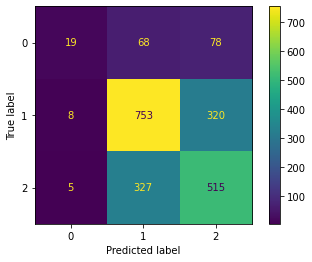

In [69]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_mnb_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with Count Vectorize


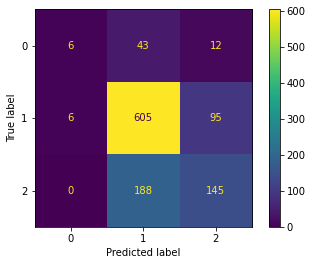

In [70]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_mnb_model_grid,X_test_goo_processed,
                         y_test_goo, 'Google',model_name)


In [71]:
# Use pipes to TfidfVectorize X_train_combined_processed and then train MultinomialNB()

start = time.time()

tf_mnb_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('mnb', MultinomialNB())])

tf_mnb_params = {'tfvect__input' : ['content'],'mnb__alpha' : [1.0]}

tf_mnb_model_grid = GridSearchCV(estimator = tf_mnb_pipe, param_grid = tf_mnb_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_mnb_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')

Training time: 0.5106990337371826


In [72]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'MultinomialNB with TF-IDF Vectorize'

display_cross_validation_results(tf_mnb_model_grid.cv_results_,model_name)

y_test_app_hat = tf_mnb_model_grid.predict(X_test_app_processed)
y_test_goo_hat = tf_mnb_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for MultinomialNB with TF-IDF Vectorize:
Accuracy: 0.6291296086631195
Recall: 0.6291296086631195 <--- Not sure!
Precision: 0.6291296086631195 <--- Not sure!

Predictions for Apple: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.6072623029144768
Recall: 0.6072623029144768
Precision: 0.6072623029144768

Predictions for Google: MultinomialNB with TF-IDF Vectorize
Accuracy: 0.6881818181818182
Recall: 0.6881818181818182
Precision: 0.6881818181818182



Confusion matrix for: Apple
Model: MultinomialNB with TF-IDF Vectorize


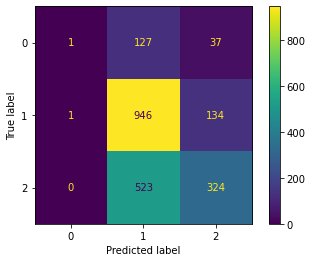

In [73]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_mnb_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)


Confusion matrix for: Google
Model: MultinomialNB with TF-IDF Vectorize


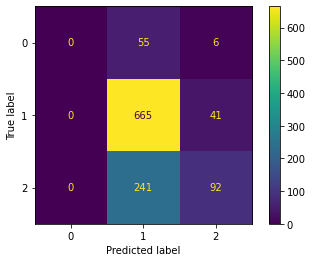

In [74]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(tf_mnb_model_grid,X_test_goo_processed,
                         y_test_goo, 'Google',model_name)


In [75]:
# Use pipes to CountVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

cv_knn_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('knn', KNeighborsClassifier())])

cv_knn_params = {'countvect__input' : ['content'],
                 'knn__n_neighbors' : [7],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [7]}  #tried 3,15,30,45

cv_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_knn_model_grid.best_params_

Training time: 1.2441809177398682


{'countvect__input': 'content',
 'knn__leaf_size': 7,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [76]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with Count Vectorize'

display_cross_validation_results(cv_knn_model_grid.cv_results_,model_name)

y_test_app_hat2 = cv_knn_model_grid.predict(X_test_app_processed)
y_test_goo_hat2 = cv_knn_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat2, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat2, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with Count Vectorize:
Accuracy: 0.5917278028285156
Recall: 0.5917278028285156 <--- Not sure!
Precision: 0.5917278028285156 <--- Not sure!

Predictions for Apple: KNeighborsClassifier with Count Vectorize
Accuracy: 0.5690396559961778
Recall: 0.5690396559961778
Precision: 0.5690396559961778

Predictions for Google: KNeighborsClassifier with Count Vectorize
Accuracy: 0.6581818181818182
Recall: 0.6581818181818182
Precision: 0.6581818181818182



Confusion matrix for: Apple
Model: KNeighborsClassifier with Count Vectorize


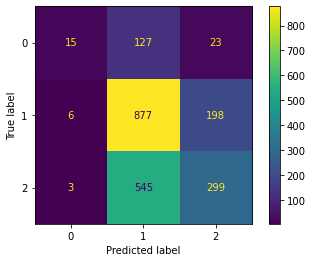

In [77]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_knn_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with Count Vectorize


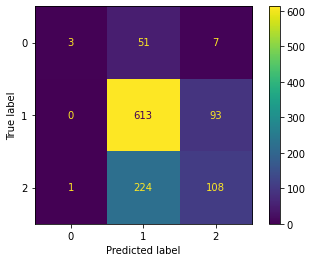

In [78]:
# Diplay confusion matrix for X_test_goo

display_confusion_matrix(cv_knn_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [79]:
# Use pipes to TfidfVectorize X_train_combined_processed and then train KNeighborsClassifier

start = time.time()

tf_knn_pipe = Pipeline([('tfvect',TfidfVectorizer()), 
                 ('knn', KNeighborsClassifier())])

tf_knn_params = {'tfvect__input' : ['content'],
                 'knn__n_neighbors' : [7],  # tried 3,7,21
                'knn__weights' : ['distance'], # tried 'uniform
                'knn__leaf_size' : [3]}  #tried 30,45

tf_knn_model_grid = GridSearchCV(estimator = cv_knn_pipe, param_grid = cv_knn_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


tf_knn_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
tf_knn_model_grid.best_params_

Training time: 1.2188339233398438


{'countvect__input': 'content',
 'knn__leaf_size': 7,
 'knn__n_neighbors': 7,
 'knn__weights': 'distance'}

In [80]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'KNeighborsClassifier with TF-IDF Vectorize'

display_cross_validation_results(tf_knn_model_grid.cv_results_,model_name)

y_test_app_hat3 = tf_knn_model_grid.predict(X_test_app)
y_test_goo_hat3 = tf_knn_model_grid.predict(X_test_goo)

display_prediction_results(y_test_app_hat3, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat3, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for KNeighborsClassifier with TF-IDF Vectorize:
Accuracy: 0.5917278028285156
Recall: 0.5917278028285156 <--- Not sure!
Precision: 0.5917278028285156 <--- Not sure!

Predictions for Apple: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.5480172001911132
Recall: 0.5480172001911132
Precision: 0.5480172001911132

Predictions for Google: KNeighborsClassifier with TF-IDF Vectorize
Accuracy: 0.6236363636363637
Recall: 0.6236363636363637
Precision: 0.6236363636363637



Confusion matrix for: Apple
Model: KNeighborsClassifier with TF-IDF Vectorize


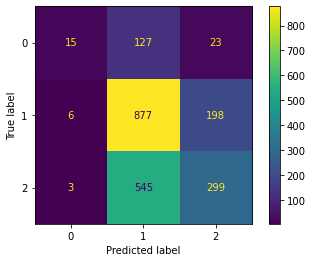

In [81]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: KNeighborsClassifier with TF-IDF Vectorize


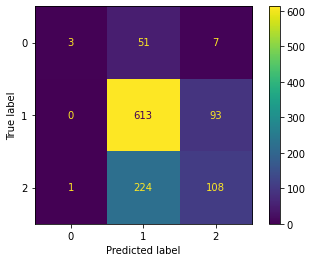

In [82]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(tf_knn_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [54]:
# RandomForestClassifier
# Use pipes to CountVectorize X_train_combined_processed and then train RandomForestClassifier

start = time.time()

cv_rf_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('rf', RandomForestClassifier())])

cv_rf_params = {'countvect__input' : ['content'],
                'rf__random_state' : [42],
                'rf__max_depth' : [87],  # tried 3,11,57,121
                'rf__criterion' : ['gini'],  #log_loss gives warning
                'rf__max_features' : [None]} # tried 'sqrt' and 'log2'

cv_rf_model_grid = GridSearchCV(estimator = cv_rf_pipe, param_grid = cv_rf_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_rf_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_rf_model_grid.best_params_


Training time: 109.85222101211548


{'countvect__input': 'content',
 'rf__criterion': 'gini',
 'rf__max_depth': 87,
 'rf__max_features': None,
 'rf__random_state': 42}

In [55]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'RandomForestClassifier with Count Vectorize'

display_cross_validation_results(cv_rf_model_grid.cv_results_,model_name)

y_test_app_hat3 = cv_rf_model_grid.predict(X_test_app_processed)
y_test_goo_hat3 = cv_rf_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat3, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat3, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for RandomForestClassifier with Count Vectorize:
Accuracy: 0.6360268148332363
Recall: 0.6360268148332363
Precision: 0.6360268148332363

Predictions for Apple: RandomForestClassifier with Count Vectorize
Accuracy: 0.6144290492116579
Recall: 0.6144290492116579
Precision: 0.6144290492116579

Predictions for Google: RandomForestClassifier with Count Vectorize
Accuracy: 0.7036363636363636
Recall: 0.7036363636363636
Precision: 0.7036363636363636



Confusion matrix for: Apple
Model: RandomForestClassifier with Count Vectorize


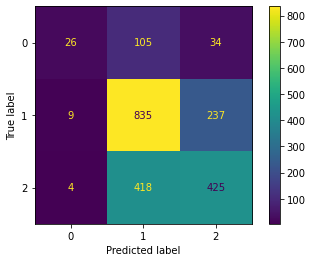

In [57]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: RandomForestClassifier with Count Vectorize


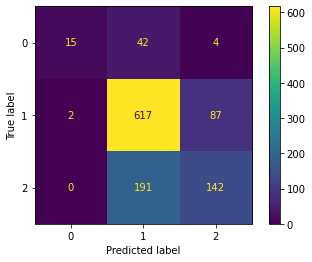

In [58]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_rf_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [64]:
# LogisticRegression
# Use pipes to CountVectorize X_train_combined_processed and then train LogisticRegression

start = time.time()

cv_lr_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('lr', LogisticRegression())])

cv_lr_params = {'countvect__input' : ['content'],
                'lr__random_state' : [321],
                'lr__penalty' : ['l2'],
                'lr__C' : [1.0,1000.0],  
                'lr__class_weight' : [None,'balanced'],
                'lr__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'lr__max_iter' : [1000,10000]}

cv_lr_model_grid = GridSearchCV(estimator = cv_lr_pipe, param_grid = cv_lr_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_lr_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_lr_model_grid.best_params_



/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Training time: 749.9014799594879


/Users/ahmadsamiee/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'countvect__input': 'content',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [65]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'LogisticRegression with Count Vectorize'

display_cross_validation_results(cv_lr_model_grid.cv_results_,model_name)

y_test_app_hat4 = cv_lr_model_grid.predict(X_test_app_processed)
y_test_goo_hat4 = cv_lr_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat4, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat4, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for LogisticRegression with Count Vectorize:
Accuracy: 0.6493995458144907
Recall: 0.6493995458144907
Precision: 0.6493995458144907

Predictions for Apple: LogisticRegression with Count Vectorize
Accuracy: 0.6311514572384138
Recall: 0.6311514572384138
Precision: 0.6311514572384138

Predictions for Google: LogisticRegression with Count Vectorize
Accuracy: 0.7027272727272728
Recall: 0.7027272727272728
Precision: 0.7027272727272728



Confusion matrix for: Apple
Model: LogisticRegression with Count Vectorize


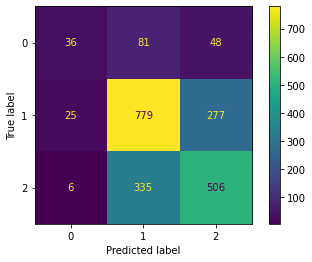

In [66]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_lr_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: LogisticRegression with Count Vectorize


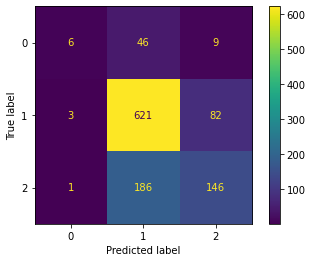

In [67]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_lr_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [76]:
# SVC
# Use pipes to CountVectorize X_train_combined_processed and then train SVC

start = time.time()

cv_svc_pipe = Pipeline([('countvect',CountVectorizer()), 
                 ('svc', SVC())])

cv_svc_params = {'countvect__input' : ['content'],
                'svc__random_state': [234],
                'svc__kernel' : ['poly','rbf', 'sigmoid'],
                'svc__degree' : [3,4,5], 
                'svc__C' : [1.0,1000.0],  
                'svc__class_weight' : [None,'balanced']}

cv_svc_model_grid = GridSearchCV(estimator = cv_svc_pipe, param_grid = cv_svc_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


cv_svc_model_grid.fit(X_train_combined_processed,y_train_combined)
end = time.time()
print(f'Training time: {end-start}')
cv_svc_model_grid.best_params_



Training time: 496.1309440135956


{'countvect__input': 'content',
 'svc__C': 1.0,
 'svc__class_weight': None,
 'svc__degree': 3,
 'svc__kernel': 'rbf',
 'svc__random_state': 234}

In [77]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'SVC with Count Vectorize'

display_cross_validation_results(cv_svc_model_grid.cv_results_,model_name)

y_test_app_hat5 = cv_svc_model_grid.predict(X_test_app_processed)
y_test_goo_hat5 = cv_svc_model_grid.predict(X_test_goo_processed)

display_prediction_results(y_test_app_hat5, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat5, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for SVC with Count Vectorize:
Accuracy: 0.6017534789257487
Recall: 0.6017534789257487
Precision: 0.6017534789257487

Predictions for Apple: SVC with Count Vectorize
Accuracy: 0.6335403726708074
Recall: 0.6335403726708074
Precision: 0.6335403726708074

Predictions for Google: SVC with Count Vectorize
Accuracy: 0.7127272727272728
Recall: 0.7127272727272728
Precision: 0.7127272727272728



Confusion matrix for: Apple
Model: SVC with Count Vectorize


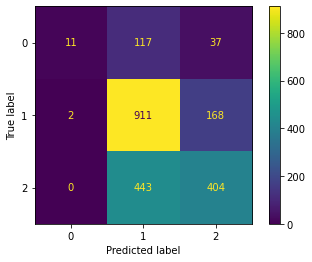

In [78]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_svc_model_grid, X_test_app_processed,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: SVC with Count Vectorize


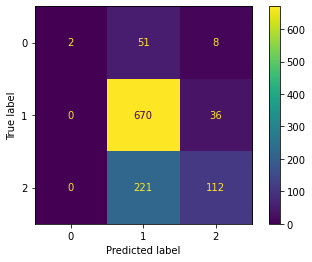

In [79]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(cv_svc_model_grid, X_test_goo_processed,
                         y_test_goo, 'Google',model_name)

In [113]:
# Balance classification ration with SMOTE

cvect = CountVectorizer()
X_train_combined_vected = cvect.fit_transform(X_train_combined_processed)

sm = SMOTE(random_state=3211)
X_train_combined_vec_sm, y_train_combined_sm = sm.fit_resample(
    X_train_combined_vected,y_train_combined)

In [114]:
# Classification ratio without SMOTE

y_train_combined.value_counts()

1    2680
2    1767
0     339
Name: sentiment, dtype: int64

In [118]:
# Classification ration with SMOTE

y_train_combined_sm.value_counts()

2    2680
1    2680
0    2680
Name: sentiment, dtype: int64

In [116]:
# Train LogisticRegression model with SMOTED data

start = time.time()

sm_lr = LogisticRegression()

sm_lr_params = {'random_state' : [4321],
                'max_iter': [1000]}

sm_lr_model_grid = GridSearchCV(estimator = sm_lr, param_grid = sm_lr_params,
                                scoring = {'accuracy' : grid_accuracy, 
                                           'recall' : grid_recall_micro,
                                          'precision' : grid_precision_micro},
                                refit = 'accuracy')


sm_lr_model_grid.fit(X_train_combined_vec_sm,y_train_combined_sm)
end = time.time()
print(f'Training time: {end-start}')
sm_lr_model_grid.best_params_


Training time: 7.654088973999023


{'max_iter': 1000, 'random_state': 4321}

In [117]:
# Display cross validation results, make prediction for X_test_app and X_test_goo
# diplay results.  Use respective functions.

model_name = 'LogisticRegression with SMOTE'

X_test_app_vec = cvect.transform(X_test_app_processed)
X_test_goo_vec = cvect.transform(X_test_goo_processed)

display_cross_validation_results(sm_lr_model_grid.cv_results_,model_name)

y_test_app_hat6 = sm_lr_model_grid.predict(X_test_app_vec)
y_test_goo_hat6 = sm_lr_model_grid.predict(X_test_goo_vec)

display_prediction_results(y_test_app_hat6, y_test_app,'Apple',model_name)

display_prediction_results(y_test_goo_hat6, y_test_goo, 'Google',model_name)


Validation ============================================================
Validation results for LogisticRegression with SMOTE:
Accuracy: 0.6471393034825871
Recall: 0.6471393034825871
Precision: 0.6471393034825871

Predictions for Apple: LogisticRegression with SMOTE
Accuracy: 0.5805064500716675
Recall: 0.5805064500716675
Precision: 0.5805064500716675

Predictions for Google: LogisticRegression with SMOTE
Accuracy: 0.6436363636363637
Recall: 0.6436363636363637
Precision: 0.6436363636363637



Confusion matrix for: Apple
Model: LogisticRegression with SMOTE


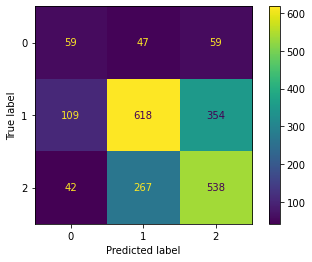

In [120]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(sm_lr_model_grid, X_test_app_vec,
                         y_test_app, 'Apple',model_name)

Confusion matrix for: Google
Model: LogisticRegression with SMOTE


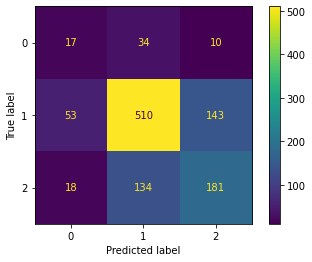

In [121]:
# Diplay confusion matrix for X_test_app

display_confusion_matrix(sm_lr_model_grid, X_test_goo_vec,
                         y_test_goo, 'Google',model_name)

In [38]:
# Prpcess target variable into one-hot encoded using pandas get_dummies 
# function for Kras / TensorFlow

y_train_comb_dum = pd.get_dummies(y_train_combined).values

y_test_app_dum = pd.get_dummies(y_test_app).values
y_test_goo_dum = pd.get_dummies(y_test_goo).values

In [80]:
# Tokenize and format X_train_combined and X_test_app & X_test_goo features
# for Kras / TensorFlow modeling

tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train_combined))

X_train_comb_tokens = tokenizer.texts_to_sequences(X_train_combined)
X_train_comb_tok = sequence.pad_sequences(X_train_comb_tokens, maxlen=200)

X_test_app_tokens = tokenizer.texts_to_sequences(X_test_app)
X_test_app_tok = sequence.pad_sequences(X_test_app_tokens)

X_test_goo_tokens = tokenizer.texts_to_sequences(X_test_goo)
X_test_goo_tok = sequence.pad_sequences(X_test_goo_tokens)

In [81]:
# Instaniate Sequential model and add layers

sq_model = Sequential()
embedding_size = 6
sq_model.add(Embedding(10000, embedding_size))
sq_model.add(LSTM(25, return_sequences=True))
sq_model.add(GlobalMaxPool1D())
sq_model.add(Dropout(0.6))
sq_model.add(Dense(50, activation='relu'))
sq_model.add(Dropout(0.6))
sq_model.add(Dense(3, activation='softmax'))

In [82]:
# Specify compiler parameters

sq_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy','Recall','Precision'])

In [83]:
sq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 6)           60000     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          3200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [84]:
# Train model with X_train_comb and y_train_comb_dum

sq_model.fit(X_train_comb_tok, y_train_comb_dum, epochs=3,
          batch_size=8, validation_split=0.1)

Epoch 1/3
539/539 [==============================] - 41s 76ms/step - loss: 0.9300 - accuracy: 0.5275 - recall: 0.2744 - precision: 0.5500 - val_loss: 0.7765 - val_accuracy: 0.6660 - val_recall: 0.6660 - val_precision: 0.6660
Epoch 2/3
539/539 [==============================] - 39s 73ms/step - loss: 0.9010 - accuracy: 0.5470 - recall: 0.4274 - precision: 0.5535 - val_loss: 0.8063 - val_accuracy: 0.6660 - val_recall: 0.6660 - val_precision: 0.6660
Epoch 3/3
539/539 [==============================] - 40s 74ms/step - loss: 0.8791 - accuracy: 0.5470 - recall: 0.4089 - precision: 0.5734 - val_loss: 0.7309 - val_accuracy: 0.6660 - val_recall: 0.5825 - val_precision: 0.7172


In [85]:
# Obtain model predictions for X_test_app and X_test_goo

y_test_app_pp = sq_model.predict(X_test_app_tok)
y_test_goo_pp = sq_model.predict(X_test_goo_tok)



In [86]:
# Convert probabilites to predicted sample target value 

y_test_app_hat10 = np.argmax(y_test_app_pp, axis=-1)
y_test_goo_hat10 = np.argmax(y_test_goo_pp, axis=-1)

In [87]:
# Display prediction results for X_test_app and X_test_goo

display_prediction_results(y_test_app_hat10, y_test_app,'Apple','Sequential')

display_prediction_results(y_test_goo_hat10, y_test_goo, 'Google','Sequential')

Predictions for Apple: Sequential
Accuracy: 0.5164835164835165
Recall: 0.5164835164835165
Precision: 0.5164835164835165

Predictions for Google: Sequential
Accuracy: 0.6418181818181818
Recall: 0.6418181818181818
Precision: 0.6418181818181818

